## Imports

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer



RANDOM_STATE = 666

## Functions and Classes

In [3]:
class LifetimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, reference_date='2018-01-01'):
        self.reference_date = reference_date

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        if 'founded_at' in X.columns and 'closed_at' in X.columns:
            mask = X['closed_at'].notna()
            X.loc[mask, 'lifetime'] = (X.loc[mask, 'closed_at'] - X.loc[mask, 'founded_at']).dt.days
            X.loc[~mask, 'lifetime'] = (datetime.strptime(self.reference_date, '%Y-%m-%d') - X.loc[~mask, 'founded_at']).dt.days
        
        elif 'lifetime' in X.columns and 'founded_at' not in X.columns:
            X['founded_at'] = (datetime.strptime(self.reference_date, '%Y-%m-%d') - pd.to_timedelta(X['lifetime'], unit='d'))

        return X

class FeatureGen_0(BaseEstimator, TransformerMixin):
    def __init__(self, na_threshold=0.05):
        self.na_threshold = na_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X['days_to_first_funding'] = (X.first_funding_at - X.founded_at).dt.days
        X['days_to_last_funding'] = (X.last_funding_at - X.founded_at).dt.days
        X['days_between_first_last'] = (X.last_funding_at - X.first_funding_at).dt.days
        X['avg_days_between_funding'] = X['days_between_first_last'] / X['funding_rounds']

        mask = X['category_list'].notna()
        X.loc[mask, 'categories_count'] = X.loc[mask, 'category_list'].apply(lambda x: len(x.split('|')))
        X.loc[~mask, 'categories_count'] = 0

        if 'closed_at' in X.columns:
            X = X.drop(columns=['closed_at'])
        na_columns = X.columns[X.isna().any()].tolist()
        for col in na_columns:
            if X[col].isna().sum() > self.na_threshold * X.shape[0]:
                X[col+'_wasna'] = X[col].isna().astype(int)

        return X    

class SentimentEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        def get_sentiment(text):
            analysis = TextBlob(text)
            return analysis.sentiment.polarity

        for col in X.columns:
            X[col+'_sentiment'] = X[col].iloc[:, ].apply(get_sentiment)
        return X

## First data analysis

In [4]:
data = pd.read_csv('datasets/kaggle_startups_train_28062024.csv', parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
test = pd.read_csv('datasets/kaggle_startups_test_28062024.csv', parse_dates=['first_funding_at', 'last_funding_at'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


<Axes: title={'center': 'Значения целевого признака для тренировочного датасета'}, xlabel='status'>

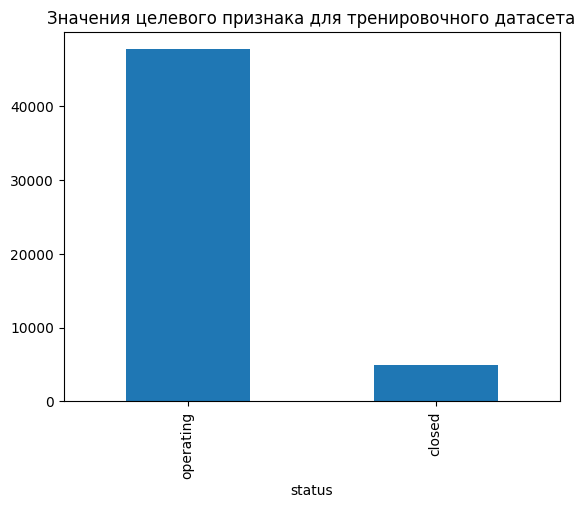

In [7]:
data.status.value_counts().plot(kind='bar', title='Значения целевого признака для тренировочного датасета',)

## First data handling

In [8]:
data[data['name'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


In [9]:
data.nunique()

name                 52515
category_list        22105
funding_total_usd    15551
status                   2
country_code           134
state_code             300
region                1036
city                  4477
funding_rounds          19
founded_at            5402
first_funding_at      4603
last_funding_at       4305
closed_at             3008
dtype: int64

In [10]:
data.category_list.sample(3)

38226    Semiconductors
12375       Web Hosting
39073               NaN
Name: category_list, dtype: object

In [11]:
data.funding_total_usd.describe()

count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

In [12]:
print(data[data.funding_total_usd.isna()][['funding_rounds']].value_counts())
print(data[data.funding_total_usd.isna()][['status']].value_counts())

funding_rounds
1                 9189
2                  706
3                  121
4                   36
5                    8
6                    3
7                    2
10                   2
8                    1
9                    1
Name: count, dtype: int64
status   
operating    9044
closed       1025
Name: count, dtype: int64


In [13]:
print(f'na funding of all data: {data.funding_total_usd.isna().sum() * 100 / data.shape[0]:.2f}%')
print(f'"closed" in na funding of all closed: {data[data.funding_total_usd.isna() & data.status.isin(["closed"])].shape[0] * 100 / data.status.isin(["closed"]).sum():.2f}%')

na funding of all data: 19.17%
"closed" in na funding of all closed: 20.85%


In [14]:
for col in data.select_dtypes(include='datetime64[ns]').columns:
    print(f'{col}: minimal date {data[col].min()} - maximum date {data[col].max()}')

founded_at: minimal date 1970-02-05 00:00:00 - maximum date 2016-04-02 00:00:00
first_funding_at: minimal date 1977-05-15 00:00:00 - maximum date 2015-12-05 00:00:00
last_funding_at: minimal date 1977-05-15 00:00:00 - maximum date 2015-12-07 00:00:00
closed_at: minimal date 1983-10-06 00:00:00 - maximum date 2017-10-21 00:00:00


In [15]:
print(data[data.isna().sum(axis=1) > 4].count())

name                 4966
category_list        3738
funding_total_usd    3006
status               4966
country_code          138
state_code              6
region                  0
city                    0
funding_rounds       4966
founded_at           4966
first_funding_at     4966
last_funding_at      4966
closed_at             615
dtype: int64


## Filled data analisys

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [17]:
txt_columns = data.select_dtypes(include='object').columns
num_columns = data.select_dtypes(include=['int64', 'float64']).columns

pipeline = Pipeline(steps=[
    ('lt_transformer', LifetimeTransformer()),
    ('feat_gen_0', FeatureGen_0()),
    ('column_filler', ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='constant', fill_value=0.0), num_columns),
            ('txt', SimpleImputer(strategy='constant', fill_value='unknown'), txt_columns)
        ],
        remainder='passthrough'
    ))
])

raw_data = pipeline.fit_transform(data)
columns = pipeline.named_steps['column_filler'].get_feature_names_out()

data_filled = pd.DataFrame(raw_data, columns=[x.split('__')[1] for x in columns])
data_filled = data_filled.infer_objects()

In [18]:
se = SentimentEncoder()
data_sentiment = se.fit_transform(data_filled[['name']])
data_filled['name_sentiment'] = data_sentiment['name_sentiment']

In [19]:
data_filled.info()
data_filled.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   funding_total_usd         52516 non-null  float64       
 1   funding_rounds            52516 non-null  float64       
 2   name                      52516 non-null  object        
 3   category_list             52516 non-null  object        
 4   status                    52516 non-null  object        
 5   country_code              52516 non-null  object        
 6   state_code                52516 non-null  object        
 7   region                    52516 non-null  object        
 8   city                      52516 non-null  object        
 9   founded_at                52516 non-null  datetime64[ns]
 10  first_funding_at          52516 non-null  datetime64[ns]
 11  last_funding_at           52516 non-null  datetime64[ns]
 12  lifetime          

,funding_total_usd,funding_rounds,name,category_list,status,country_code,state_code,region,city,founded_at,...,days_to_last_funding,days_between_first_last,avg_days_between_funding,categories_count,funding_total_usd_wasna,country_code_wasna,state_code_wasna,region_wasna,city_wasna,name_sentiment
0,828626.0,2.0,Lunchgate,Online Reservations|Restaurants,operating,CHE,25,Zurich,Zürich,2009-10-17,...,1871,1310,655.000000,2.0,0,0,0,0,0,0.0
1,42935019.0,4.0,EarLens,Manufacturing|Medical|Medical Devices,operating,USA,CA,SF Bay Area,Redwood City,2005-01-01,...,3342,1393,348.250000,3.0,0,0,0,0,0,0.0
2,35456381.0,3.0,Reviva Pharmaceuticals,Biotechnology,operating,USA,CA,SF Bay Area,San Jose,2006-01-01,...,3104,681,227.000000,1.0,0,0,0,0,0,0.0
3,22250000.0,3.0,Sancilio and Company,Health Care,operating,unknown,unknown,unknown,unknown,2004-01-01,...,3851,1051,350.333333,1.0,0,1,1,1,1,0.0
4,0.0,1.0,WireTough Cylinders,Manufacturing,operating,USA,VA,VA - Other,Bristol,2010-05-12,...,630,0,0.000000,1.0,1,0,0,0,0,0.0


In [33]:
data_filled['funding_total_usd_log'] = np.log1p(data_filled['funding_total_usd'])
data_filled['funding_total_usd_log'].describe()

count    52516.000000
mean        11.612687
std          6.052001
min          0.000000
25%         10.596660
50%         13.815512
75%         15.730804
max         24.127110
Name: funding_total_usd_log, dtype: float64

In [20]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Создаем TF-IDF векторизатор
# vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split('|'))

# # Преобразуем данные
# tfidf_matrix = vectorizer.fit_transform(data_filled['category_list'])

# # Преобразуем результат в DataFrame
# tfidf_df = pd.DataFrame(
#     tfidf_matrix.toarray(),
#     columns=vectorizer.get_feature_names_out()
# )

# print(tfidf_df.columns)

In [41]:
display(data_filled.nunique())
cat_columns = ['funding_rounds', 'categories_count', 'funding_total_usd_wasna', 'country_code_wasna', 'state_code_wasna', 'region_wasna', 'city_wasna']
num_columns = ['funding_total_usd', 'lifetime', 'days_to_first_funding', 'days_to_last_funding', 'days_between_first_last', 'avg_days_between_funding', 'name_sentiment', 'funding_total_usd_log']
high_cardinality_columns = ['category_list', 'country_code', 'state_code', 'region', 'city']

funding_total_usd           15552
funding_rounds                 19
name                        52516
category_list               22106
status                          2
country_code                  135
state_code                    301
region                       1037
city                         4478
founded_at                   5402
first_funding_at             4603
last_funding_at              4305
lifetime                     5738
days_to_first_funding        6439
days_to_last_funding         6925
days_between_first_last      3243
avg_days_between_funding     5508
categories_count               25
funding_total_usd_wasna         2
country_code_wasna              2
state_code_wasna                2
region_wasna                    2
city_wasna                      2
name_sentiment                135
funding_total_usd_log       15552
dtype: int64

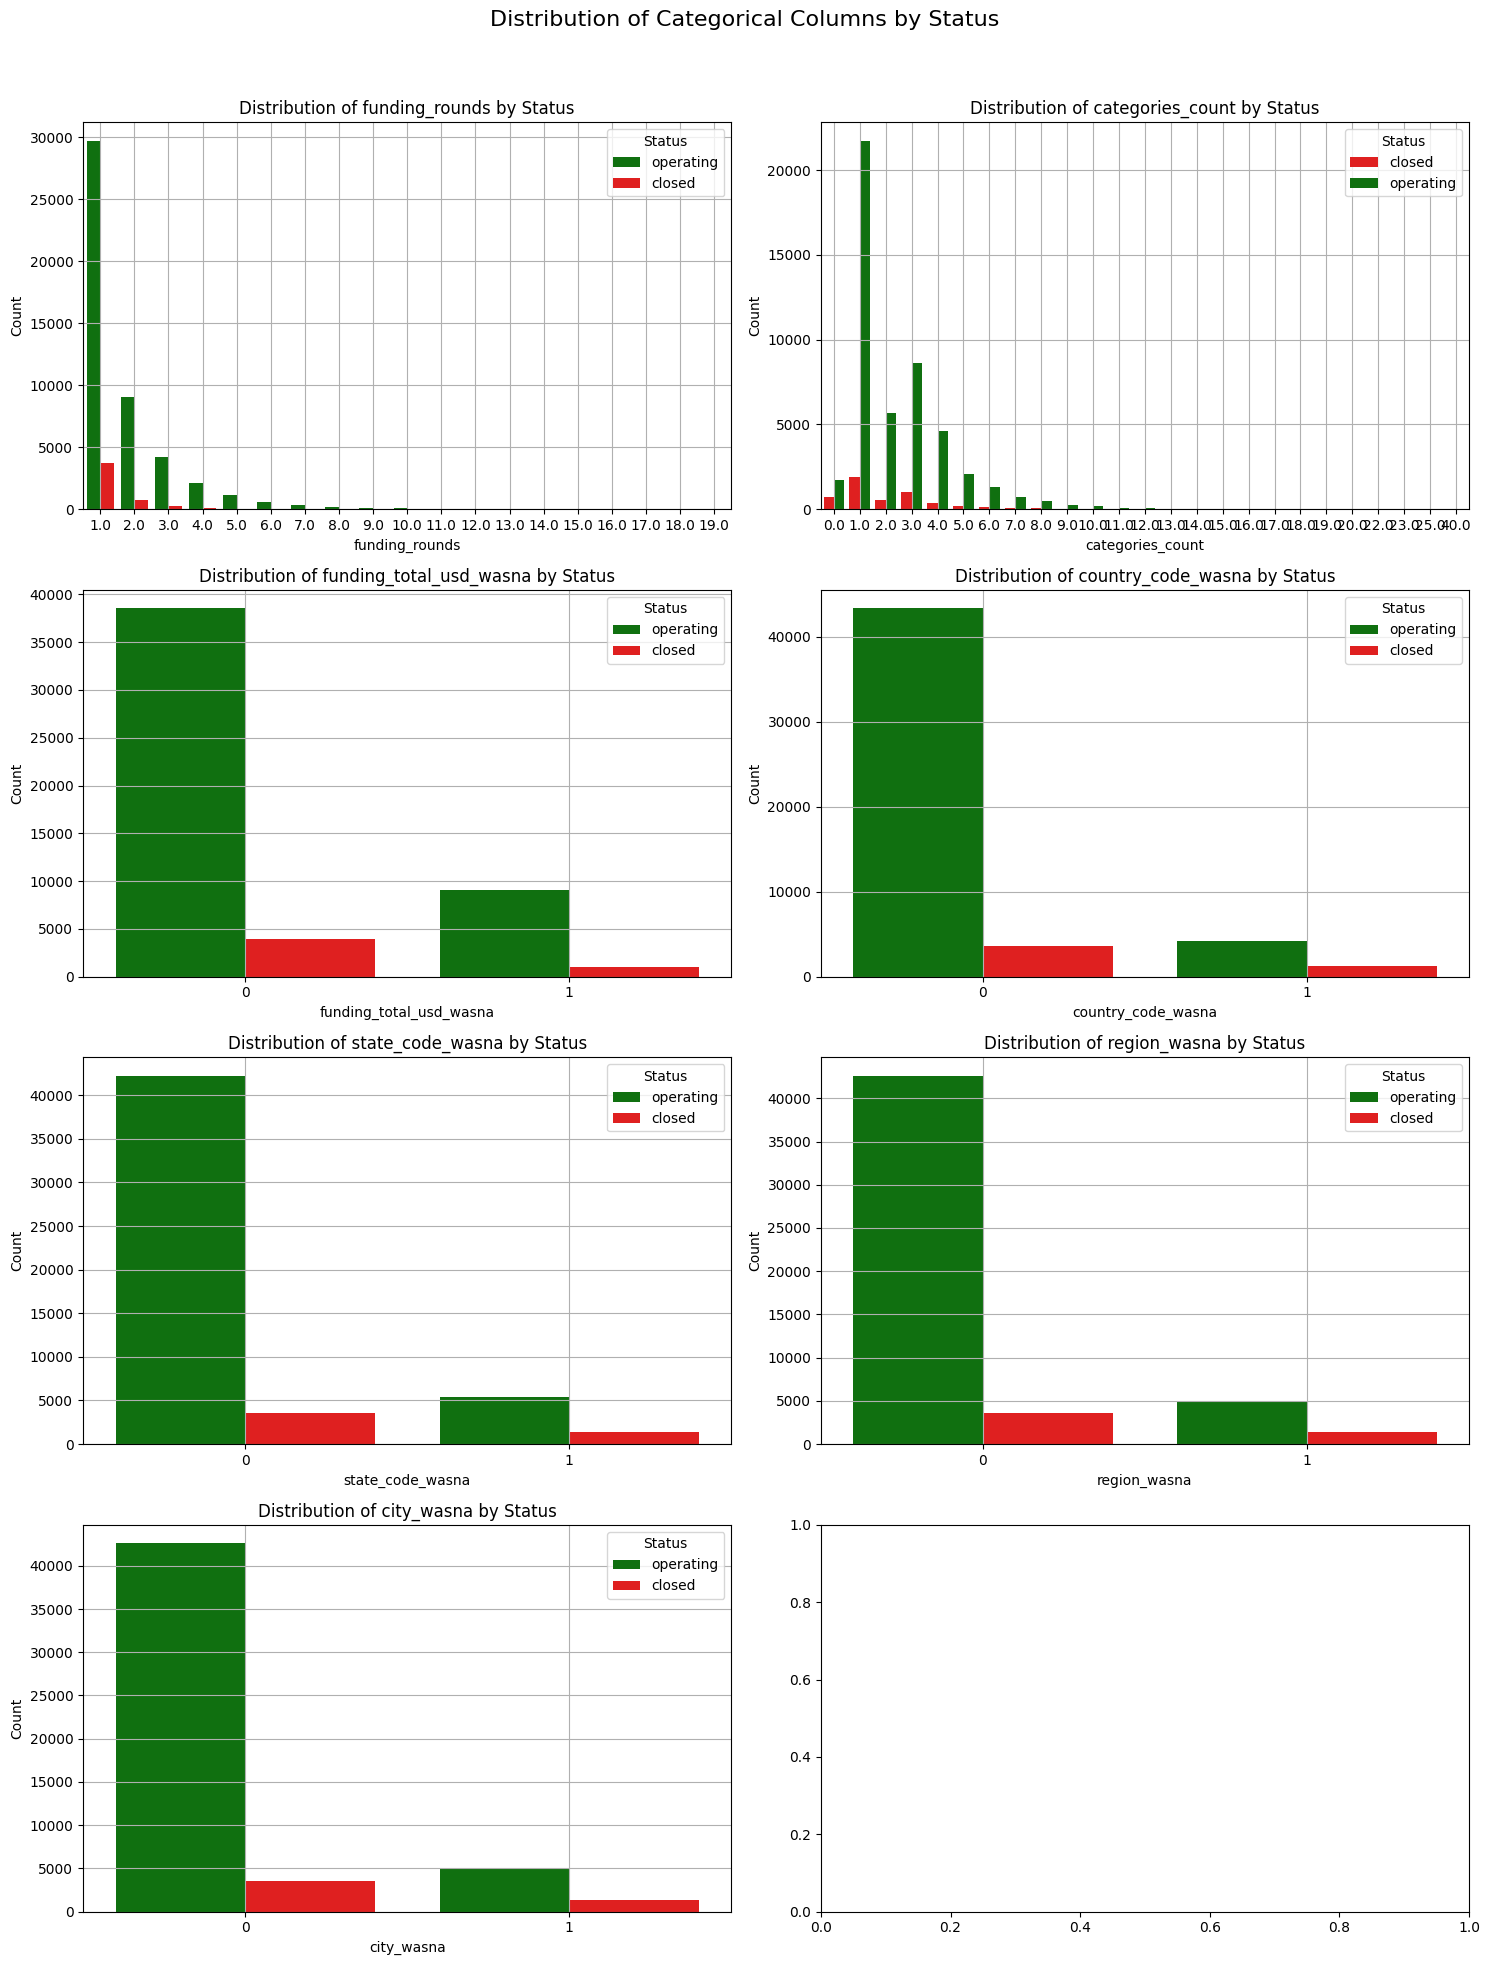

In [37]:
fig, axes = plt.subplots(nrows=(len(cat_columns) + 1) // 2, ncols=2, figsize=(15, 20))
fig.suptitle('Distribution of Categorical Columns by Status', fontsize=16)

for i, col in enumerate(cat_columns):
    ax = axes[i // 2, i % 2]
    sns.countplot(data=data_filled, x=col, hue='status', ax=ax, palette={'operating': 'green', 'closed': 'red'})
    ax.set_title(f'Distribution of {col} by Status')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend(title='Status')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

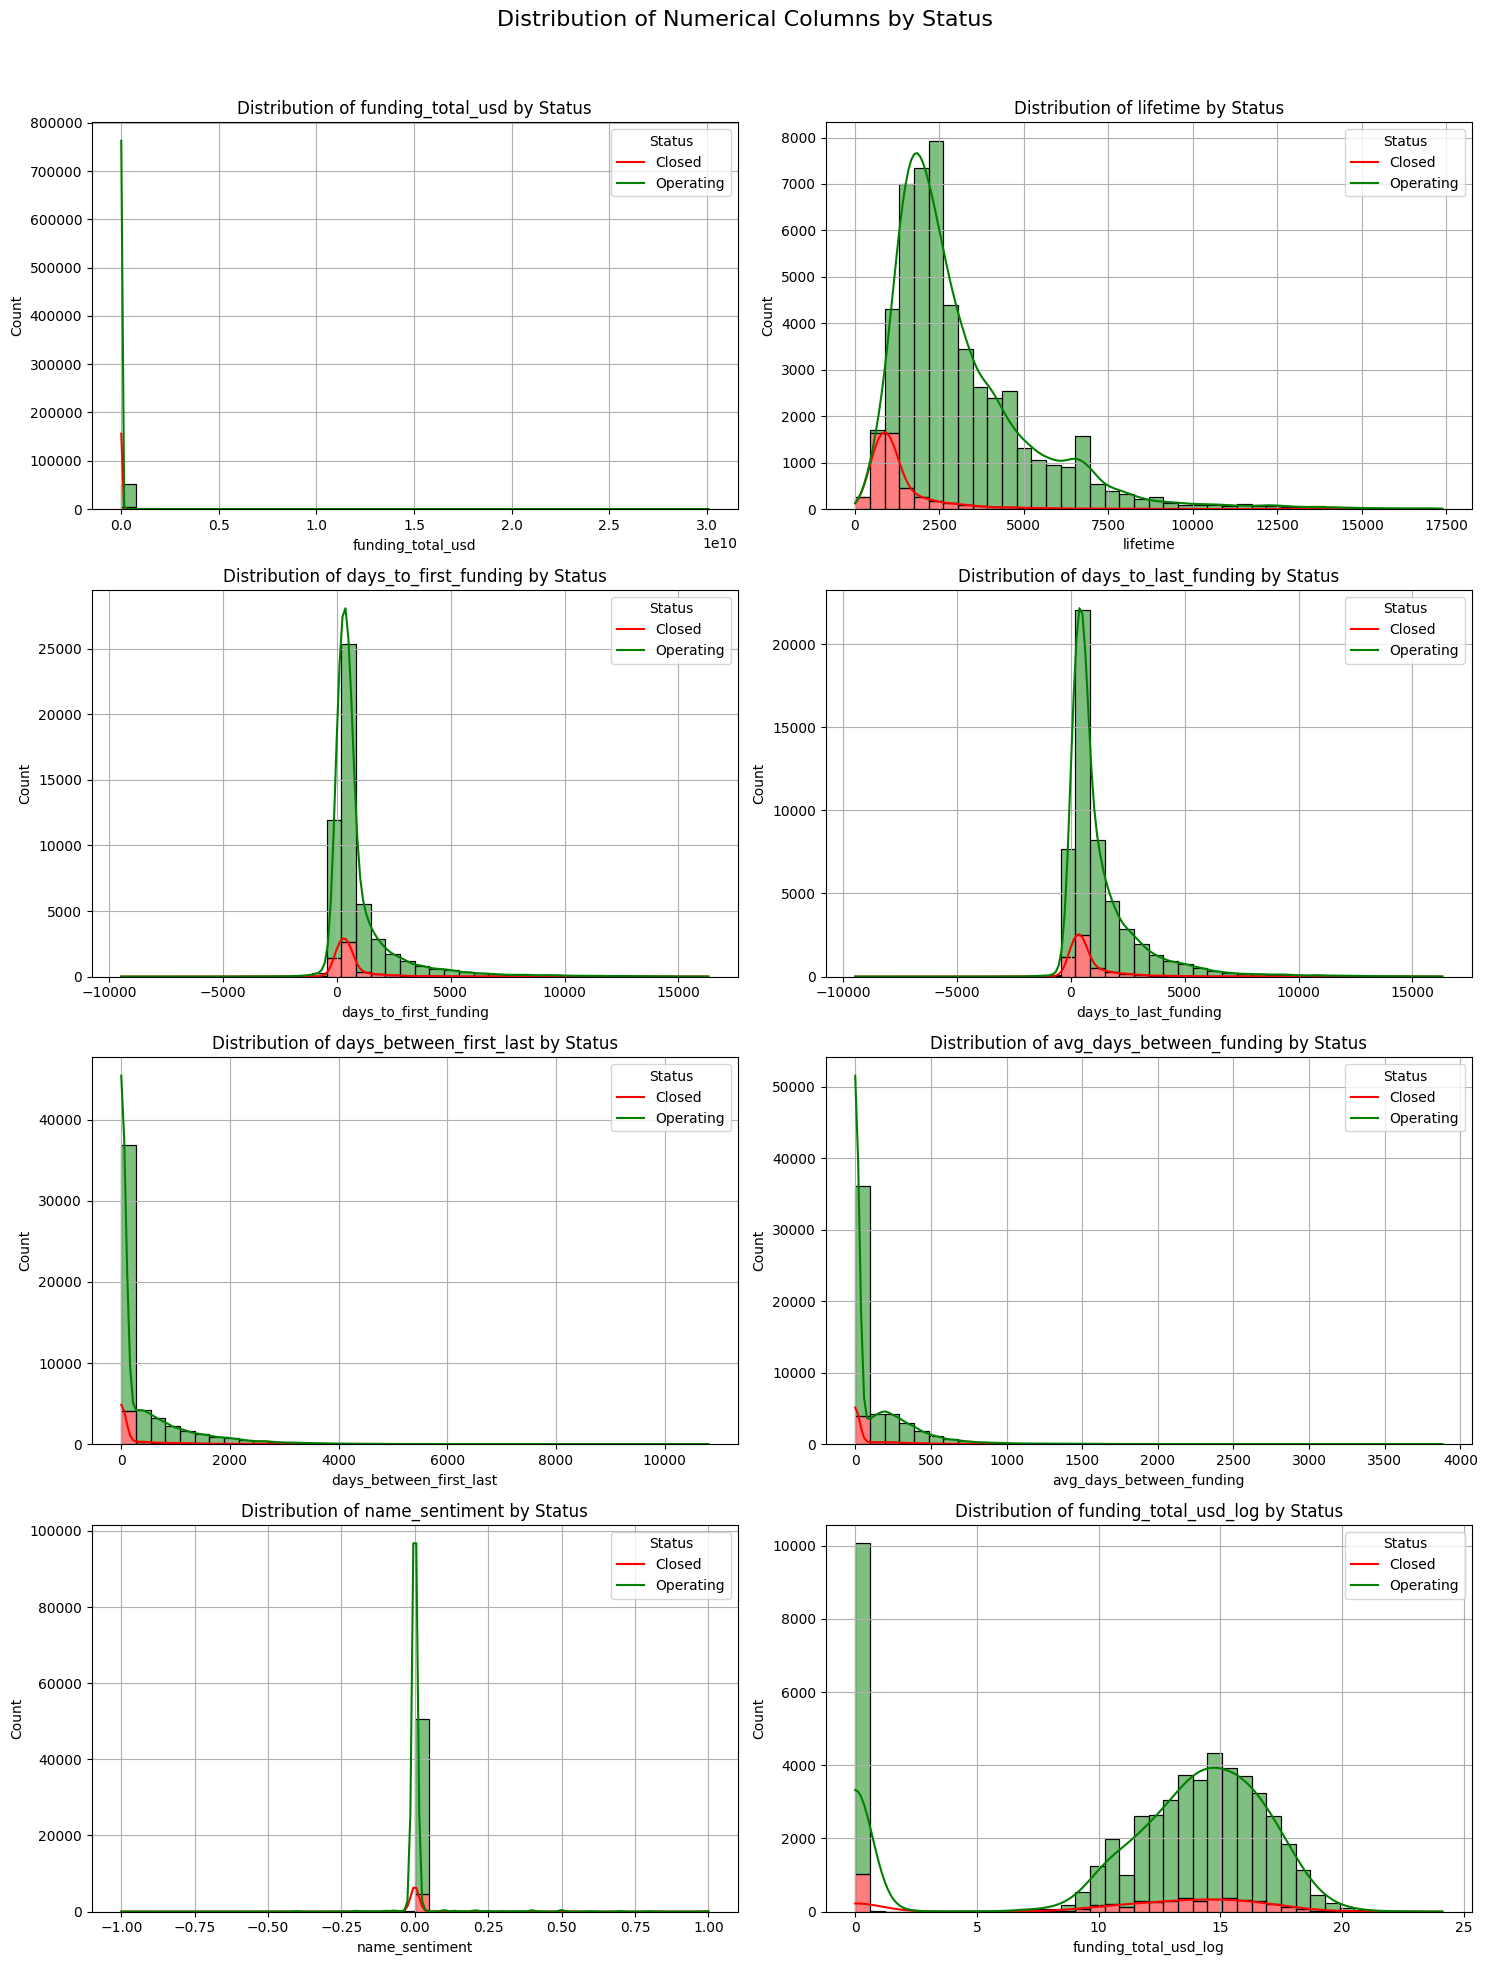

In [38]:
fig, axes = plt.subplots(nrows=(len(num_columns) + 1) // 2, ncols=2, figsize=(15, 20))
fig.suptitle('Distribution of Numerical Columns by Status', fontsize=16)

for i, col in enumerate(num_columns):
    ax = axes[i // 2, i % 2]
    hist = sns.histplot(data=data_filled, x=col, hue='status', bins=40, multiple='stack', ax=ax, palette={'operating': 'green', 'closed': 'red'}, kde=True)
    ax.set_title(f'Distribution of {col} by Status')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend(labels=['Closed', 'Operating'], title='Status')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

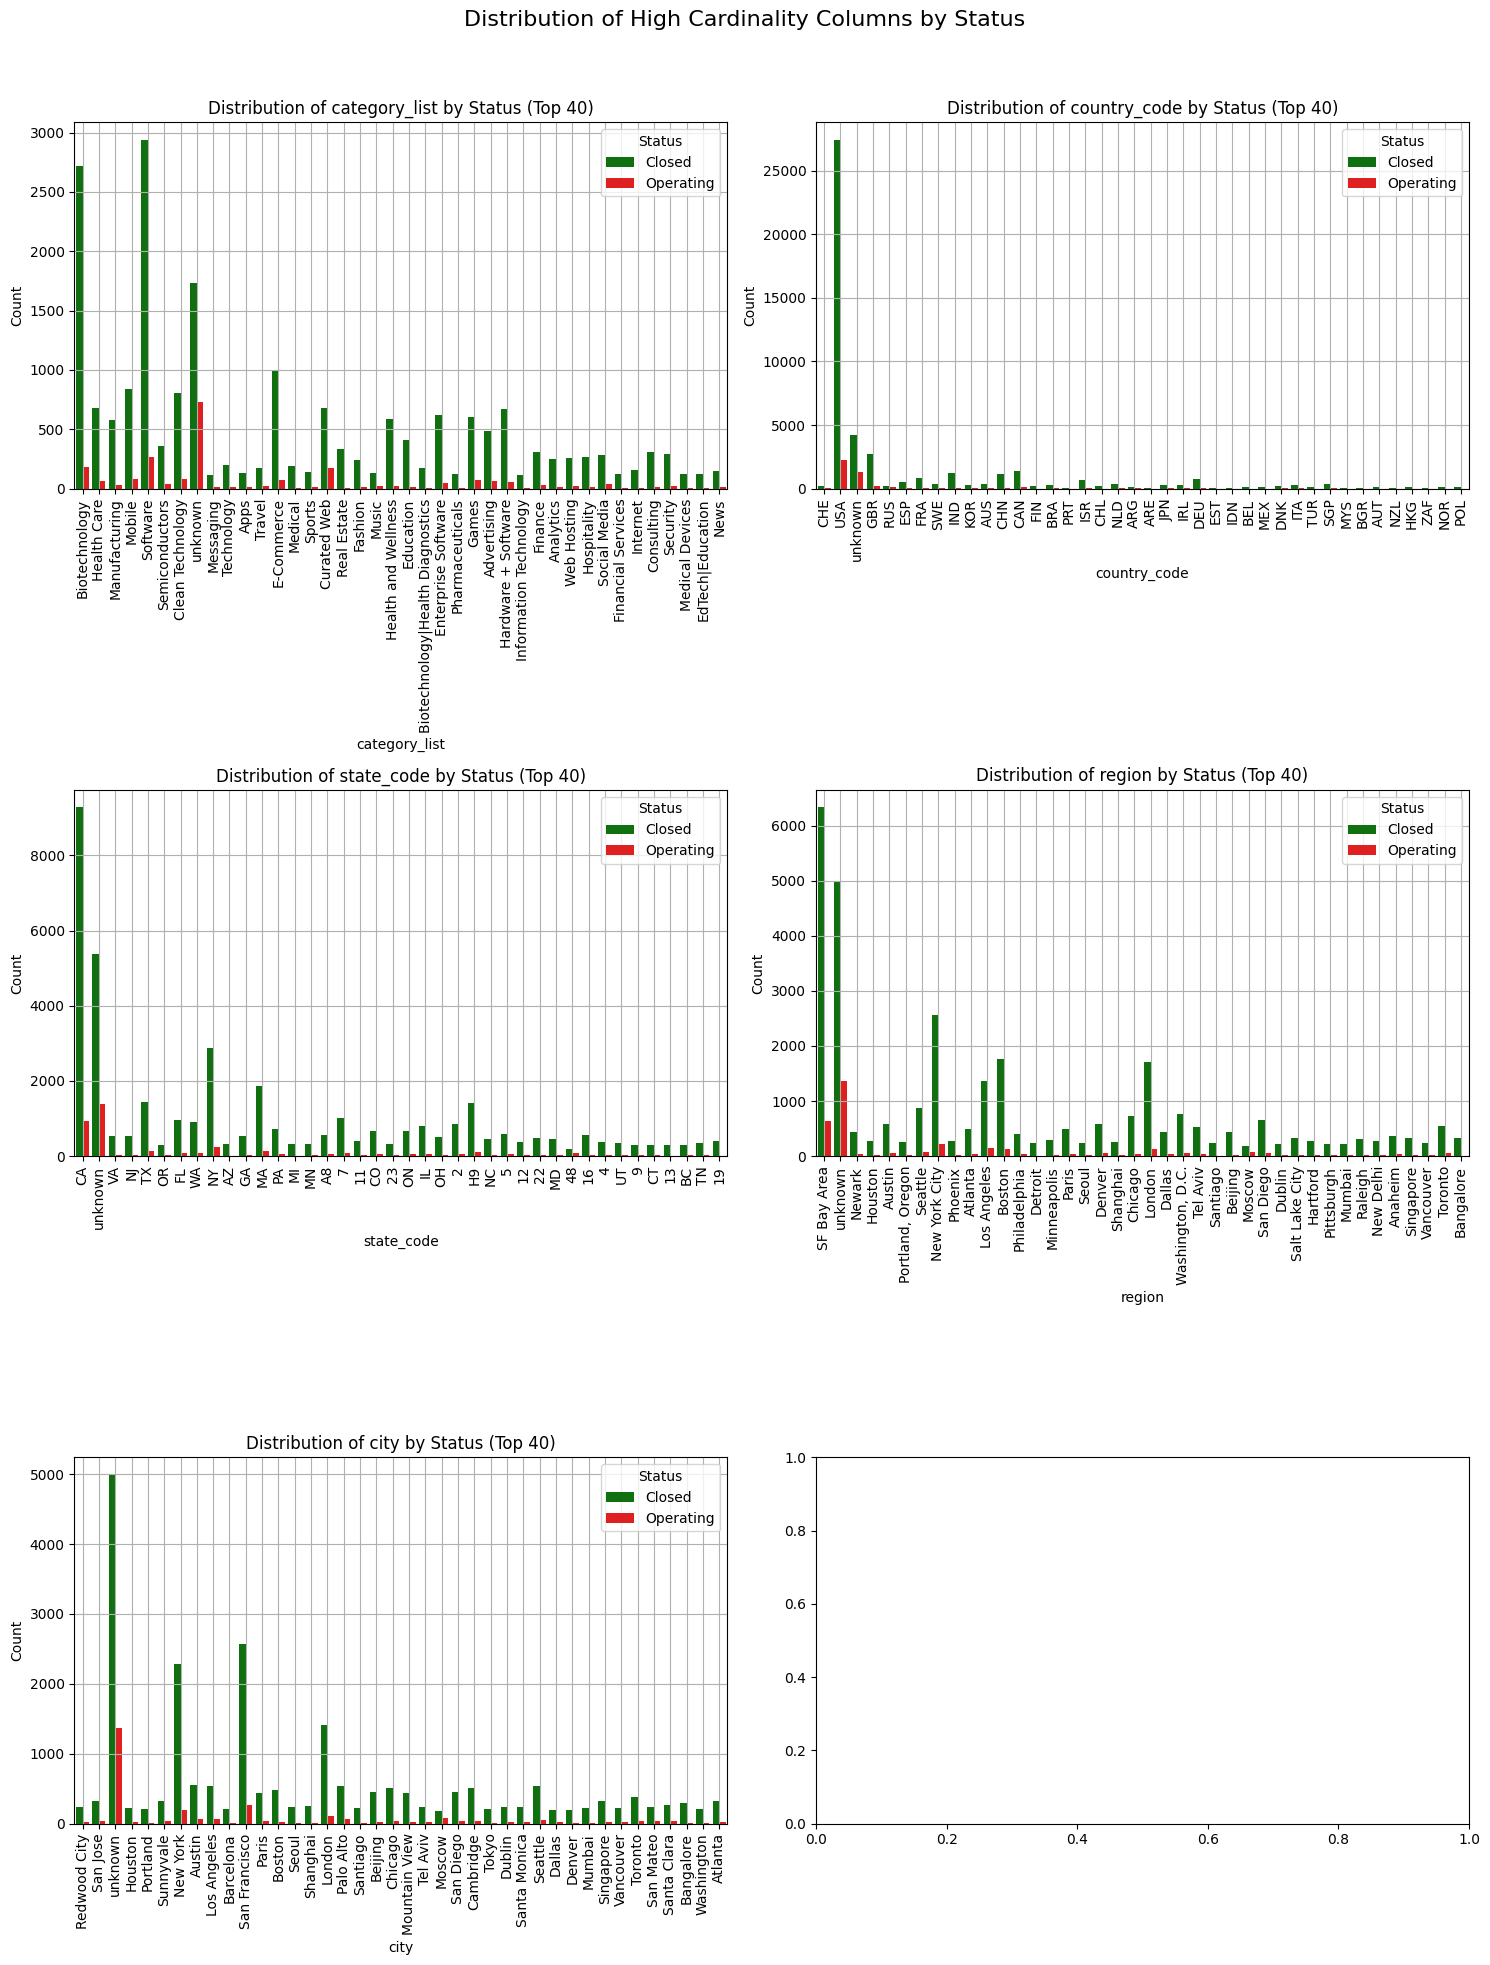

In [42]:
fig, axes = plt.subplots(nrows=(len(high_cardinality_columns) + 1) // 2, ncols=2, figsize=(15, 20))
fig.suptitle('Distribution of High Cardinality Columns by Status', fontsize=16)

for i, col in enumerate(high_cardinality_columns):
    ax = axes[i // 2, i % 2]
    top_values = data_filled[col].value_counts().nlargest(40).index
    sns.countplot(data=data_filled[data_filled[col].isin(top_values)], x=col, hue='status', ax=ax, palette={'operating': 'green', 'closed': 'red'})
    ax.set_title(f'Distribution of {col} by Status (Top 40)')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend(labels=['Closed', 'Operating'], title='Status')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()